<a href="https://colab.research.google.com/github/vpolyakov/hello_world/blob/master/face_mask_detection_skillfactory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Детекция маски на лице с помощью OpenCV и глубокого обучения

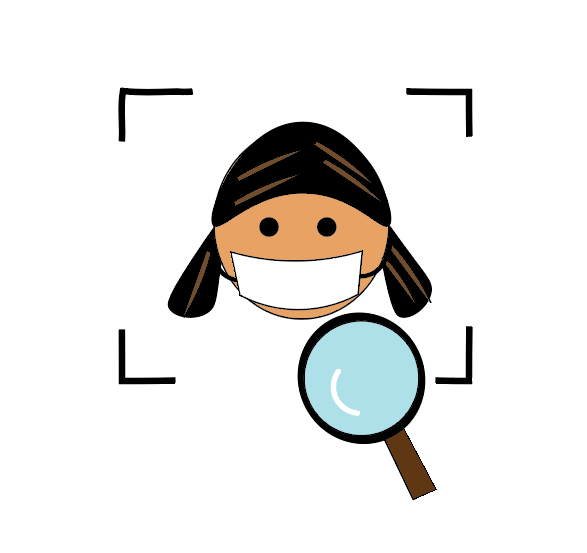

Задачу можно разбить на 2 этапа:
1. Находим лицо на фотографии
2. Классифицируем есть ли маска на лице

# 1. Детекция лиц с помощью OpenCV

Быстрая и точная детекция лиц с помощью OpenCV, используя предварительно обученную модель детектора лиц, поставляемую вместе с библиотекой.

Таким образом, нам не придется с нуля писать нашу модель и обучать ее, подбирая необходимые веса - есть уже готовы решения, которые помогут нам в нашей задаче!

Import required Python libraries

In [ ]:
import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import argparse
import os
import sys

import warnings
warnings.simplefilter("ignore", UserWarning)

In [ ]:
import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.7.11 (default, Jul  3 2021, 18:01:19) 
Numpy        : 1.19.5
Tensorflow   : 2.5.0
Keras        : 2.5.0


In [ ]:
# Устаналиваем конкретное значение random seed для воспроизводимости
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

Скачаем фотографию для примера (можете вставить любую свою)

In [ ]:
!wget -O sample.jpg https://m.buro247.ru/images/2017/11/625-625-GettyImages-856433996.jpg

--2021-08-15 17:31:11--  https://m.buro247.ru/images/2017/11/625-625-GettyImages-856433996.jpg
Resolving m.buro247.ru (m.buro247.ru)... 89.208.156.120
Connecting to m.buro247.ru (m.buro247.ru)|89.208.156.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 188207 (184K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>] 183.80K   356KB/s    in 0.5s    

2021-08-15 17:31:13 (356 KB/s) - ‘sample.jpg’ saved [188207/188207]



Читаем и измением размер изображения.    
Read, resize and display the image. 

400 400


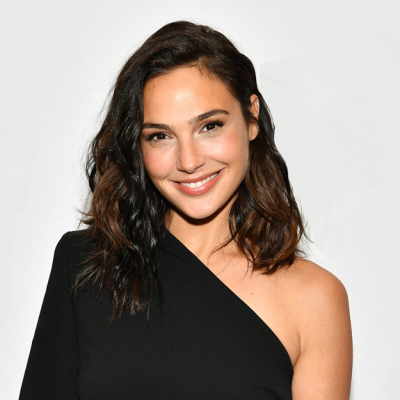

In [ ]:
image = cv2.imread('sample.jpg')

# изменяем его размер до максимальной ширины 400 пикселей
# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)

Детектор лиц с глубоким обучением OpenCV основан на платформе Single Shot Detector (SSD) с базовой сетью ResNet. Сеть определяется и обучается с использованием фреймворка [Caffe Deep Learning framework](https://caffe.berkeleyvision.org/)

При использовании глубокого нейросетевого модуля OpenCV с моделями Caffe вам понадобится два набора файлов:

- Файлы .prototxt, которые определяют архитектуру модели (deploy.prototxt)
- Файл .caffemodel, который содержит веса для фактических слоев (res10_300x300_ssd_iter_140000.caffemodel) 
Оба файла необходимы при использовании моделей, обученных с помощью Caffe для глубокого обучения.

Скачаем уже обученную модель детекции лица:

In [ ]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2021-08-15 17:31:31--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2021-08-15 17:31:31 (81.0 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2021-08-15 17:31:31--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

Загрузим уже обученную модель детекции лица с диска:

In [ ]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model_w = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model_w)

[INFO] loading model...


Функция [dnn.blobFromImage](https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/)  позаботится о предварительной обработке, которая включает в себя обрезку до нужного размера (300x300 pixels) для модели и нормализацию


In [ ]:
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

Передадим полученные данные в сеть для предсказания

In [ ]:
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing object detections...


In [ ]:
detections

array([[[[0.        , 1.        , 0.99987495, ..., 0.16827968,
          0.6229284 , 0.5477835 ],
         [0.        , 1.        , 0.09284545, ..., 0.48921552,
          0.70581526, 0.65036833],
         [0.        , 1.        , 0.09191497, ..., 0.20060459,
          0.6520829 , 0.29198614],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]]], dtype=float32)

Для удобства "Завернем" всю обработу в эту функцию чтоб нарисовать рамки вокруг обнаруженных лиц.

In [ ]:
def draw_bb(image):
  '''
  функция Рисует рамки вокруг обнаруженных лиц 
  основываясь на вероятности нахождения лица в этом месте от DL модели

    Параметры:
            image : изображение
    Возвращаемое значение:
            image : итоговое изображение
  '''
  # Функция dnn.blobFromImage позаботится о предварительной обработке, 
  # которая включает в себя обрезку до нужного размера (300x300 pixels) для модели и нормализацию
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
  
  # Передадим полученные данные в сеть для предсказания
  net.setInput(blob)
  detections = net.forward()

  for i in range(0, detections.shape[2]):
    # извлекаем достоверность (т.е. вероятность) нахождения лица в этом месте
    # extract the confidence (i.e., probability) associated with the prediction
    confidence = detections[0, 0, i, 2]

    # отфильтровываем слабые обнаружения, убедившись, что вероятность
    # больше минимального порога достоверности (confidence > 0.5)

    # filter out weak detections by ensuring the `confidence` is
    # greater than the minimum confidence threshold
    if confidence > 0.5:
      # вычисляем (x, y) - координаты ограничивающего прямоугольника объекта
      # compute the (x, y)-coordinates of the bounding box for the object
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")
    
      # рисуем ограничивающую рамку лица вместе с соответствующей вероятностью
      # draw the bounding box of the face along with the associated probability
      text = "{:.2f}%".format(confidence * 100)
      y = startY - 10 if startY - 10 > 10 else startY + 10
      cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
      cv2.putText(image, text, (startX, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
  return image

Смотрим получившееся изображение

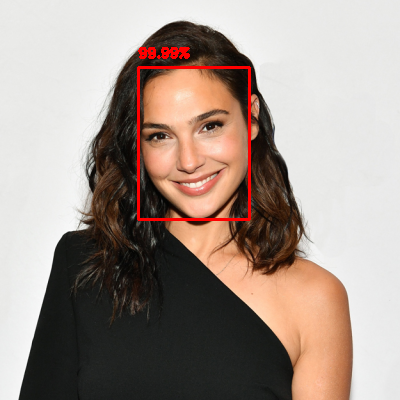

In [ ]:
image_result = draw_bb(image)
cv2_imshow(image_result)

# Фото C Webcam

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Сделаем снимок с вебкамеры     
Click 'Capture' to make photo using your webcam.

In [ ]:
image_file = take_photo()

<IPython.core.display.Javascript object>

400 300


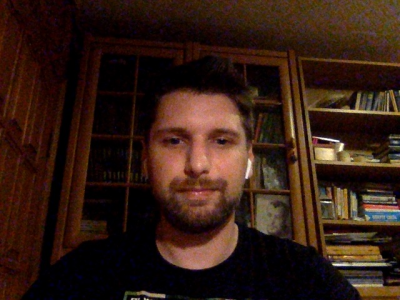

In [ ]:
image = cv2.imread(image_file)

# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)

Смотрим получившееся изображение

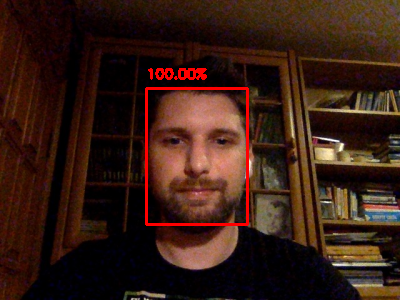

In [ ]:
image = draw_bb(image)
cv2_imshow(image)

# 2. Распознавание маски на лице
Первую задачу мы уже умеем решать, теперь потребуется модель классификатор, которая определяет наличия маски на лице.

### План на модель Классификатора наличия маски:     
1) Подгружаем веса обученной сети под нашу задачу      
2) Интегрируем код модели в детектор.   

Поехали!

### 1) Подгружаем веса обученной сети под нашу задачу

In [ ]:
!git clone https://github.com/chandrikadeb7/Face-Mask-Detection

Cloning into 'Face-Mask-Detection'...
remote: Enumerating objects: 4524, done.
remote: Total 4524 (delta 0), reused 0 (delta 0), pack-reused 4524
Receiving objects: 100% (4524/4524), 186.69 MiB | 29.52 MiB/s, done.
Resolving deltas: 100% (239/239), done.
Checking out files: 100% (4151/4151), done.


название модели MobileNetV2 и обучена она изначально на датасете imagenet, а потом дообучена под нашу задачу

In [ ]:
print("[INFO] loading face mask detector model...")
model = load_model('./Face-Mask-Detection/mask_detector.model')

[INFO] loading face mask detector model...


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

### 2) Интегрируем код модели в детектор.
для этого отредактируем нашу функцию добавив детекцию маски после лица

In [ ]:
def draw_bb(image):
  '''
  функция детектирует наличие маски на лице

      Параметры:
            image : изображение
    Возвращаемое значение:
            image : итоговое изображение
  '''
  # Функция dnn.blobFromImage позаботится о предварительной обработке, 
  # которая включает в себя обрезку до нужного размера (300x300 pixels) для модели и нормализацию
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
  
  # Передадим полученные данные в сеть для предсказания
  net.setInput(blob)
  detections = net.forward()

  for i in range(0, detections.shape[2]):
    # извлекаем достоверность (т.е. вероятность) нахождения лица в этом месте
    # extract the confidence (i.e., probability) associated with the prediction
    confidence = detections[0, 0, i, 2]

    # отфильтровываем слабые обнаружения, убедившись, что вероятность
    # больше минимального порога достоверности (confidence > 0.5)

    # filter out weak detections by ensuring the `confidence` is
    # greater than the minimum confidence threshold
    if confidence > 0.5:
        # вычисляем (x, y) - координаты ограничивающего прямоугольника объекта
        # compute the (x, y)-coordinates of the bounding box for the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        ############ добавили вот этот кусок кода ##########################
        # ensure the bounding boxes fall within the dimensions of
        # the frame
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

        # extract the face ROI, convert it from BGR to RGB channel
        # ordering, resize it to 224x224, and preprocess it
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)

        # pass the face through the model to determine if the face
        # has a mask or not
        model = tf.keras.models.load_model('./Face-Mask-Detection/mask_detector.model')
        (mask, withoutMask) = model.predict(face)[0]

        # determine the class label and color we'll use to draw
        # the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        ####################################################################

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(image, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

  return image

Смотрим получившееся изображение

400 400


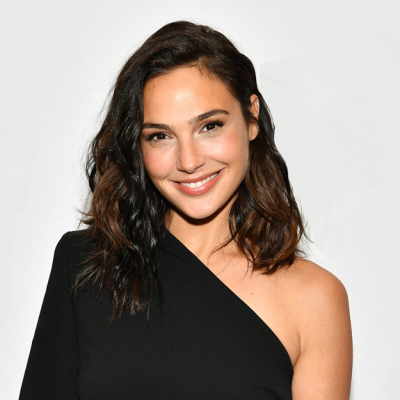

In [ ]:
image = cv2.imread('sample.jpg')

# изменяем его размер до максимальной ширины 400 пикселей
# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)

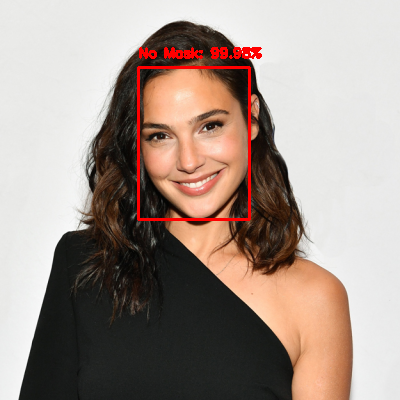

In [ ]:
image_result = draw_bb(image)
cv2_imshow(image_result)

давайте скачаем изображение с маской

In [ ]:
!wget -O mask_sample.jpg https://i.pinimg.com/564x/cd/7c/5e/cd7c5ec4a8ee9e0aca4e3fbc828e73ba.jpg

--2021-08-15 17:41:05--  https://i.pinimg.com/564x/cd/7c/5e/cd7c5ec4a8ee9e0aca4e3fbc828e73ba.jpg
Resolving i.pinimg.com (i.pinimg.com)... 151.101.40.84, 2a04:4e42:a::84
Connecting to i.pinimg.com (i.pinimg.com)|151.101.40.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24345 (24K) [image/jpeg]
Saving to: ‘mask_sample.jpg’

mask_sample.jpg     100%[===================>]  23.77K  --.-KB/s    in 0.002s  

2021-08-15 17:41:05 (11.4 MB/s) - ‘mask_sample.jpg’ saved [24345/24345]



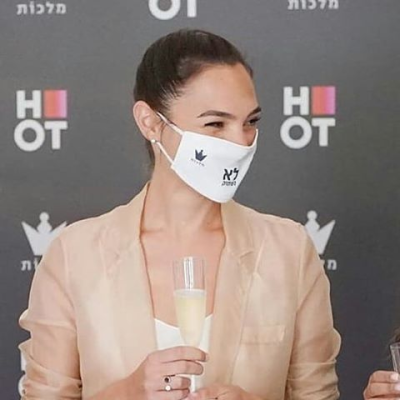

In [ ]:
image = cv2.imread('mask_sample.jpg')
image = imutils.resize(image, width=400)
cv2_imshow(image)

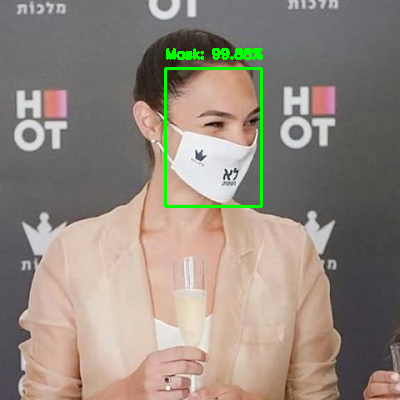

In [ ]:
image_result = draw_bb(image)
cv2_imshow(image_result)

# Фото C Webcam

In [ ]:
image_file = take_photo()

<IPython.core.display.Javascript object>

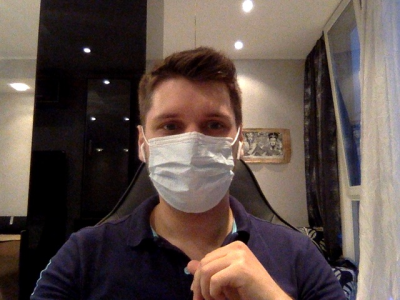

In [ ]:
image = cv2.imread(image_file)
image = imutils.resize(image, width=400)
cv2_imshow(image)

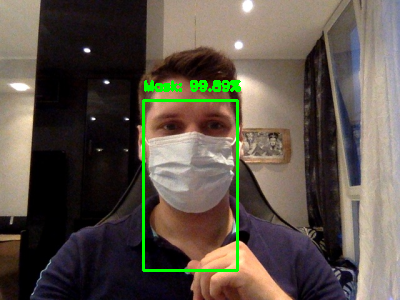

In [ ]:
image_result = draw_bb(image)
cv2_imshow(image_result)

# APP
https://face-mask--detection-app.herokuapp.com/